The deep-water
\begin{equation}
    |k|h \gg 1 \implies \tanh(kh) \approx \mathop{sgn}(k)
\end{equation}
and negligible-surface-tension limit of the dispersion relation is
\begin{equation}
    \omega^2 = g|k|.
\end{equation}

In [61]:
import numpy as np
import matplotlib.pyplot as plt

def solve_wave_dispersion(t, g, h, gamma, sigma, k0, N, L):
    '''
    Computes the profile of a dispersive wave packet at a given time t.
    '''
    dx = L / N
    x = np.linspace(-L / 2, L / 2, N, endpoint=False)
    k = 2 * np.pi * np.fft.fftfreq(N, d=dx)
    F_x_0 = np.exp(-x**2 / sigma**2) * np.cos(k0 * x)
    A_k_0 = np.fft.fft(F_x_0)
    omega_sq = (g * np.abs(k) + (gamma / 1000) * np.abs(k)**3) * np.tanh(np.abs(k) * h)
    omega = np.sqrt(omega_sq)
    time_evolution_factor = np.cos(omega * t)
    A_k_t = A_k_0 * time_evolution_factor
    F_x_t = np.real(np.fft.ifft(A_k_t))

    return x, F_x_t

def calculate_rmse(numerical, analytical):
    '''
    Calculates the Root Mean Square Error between two signals.
    '''
    return np.sqrt(np.mean((numerical - analytical)**2))

RMSE results:
L= 32, N=  32 | RMSE = 0.0431
L= 32, N= 256 | RMSE = 0.0423
L=256, N=  32 | RMSE = 0.1187
L=256, N= 256 | RMSE = 0.0029


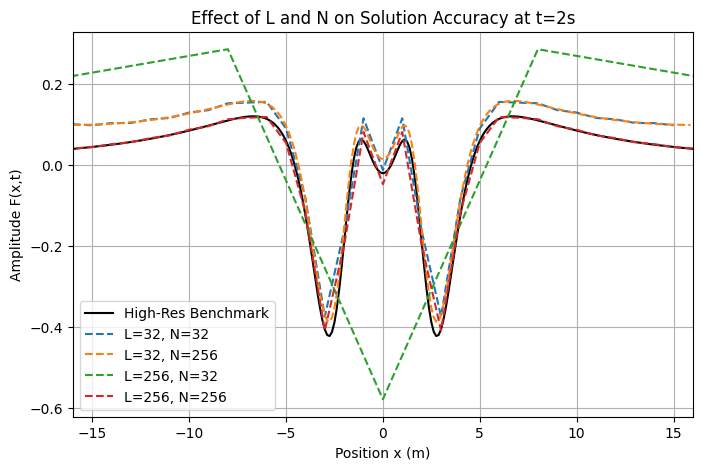

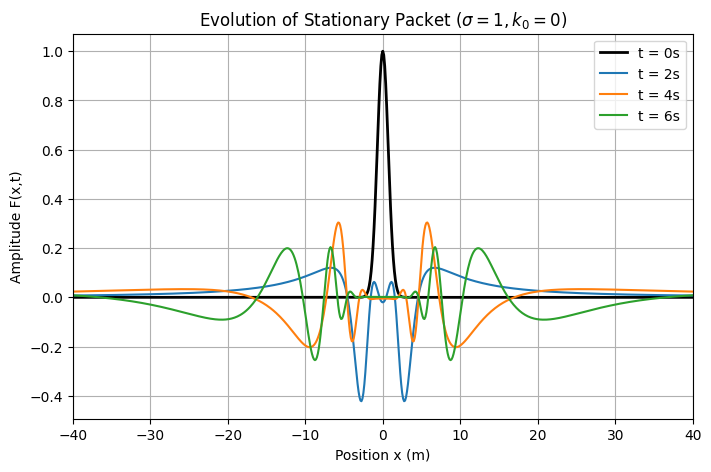

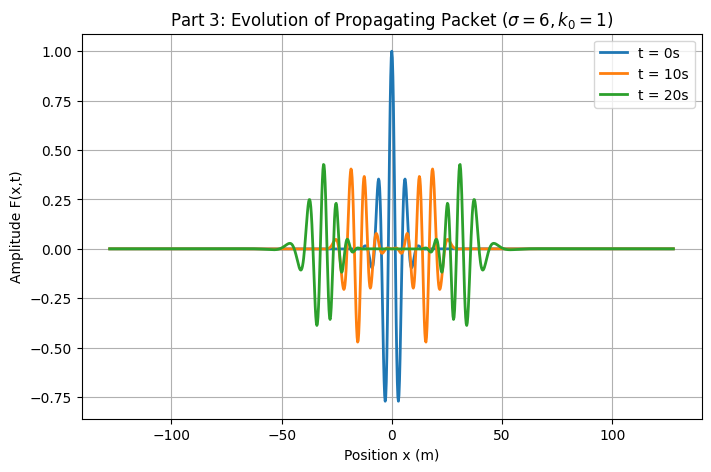

In [62]:
def investigate_L_and_N():
    '''
    Investigates the effect of L and N on the accuracy of the solution.
    '''
    t_solve = 2.0
    # Generate a high-resolution solution
    x_true, sol_true = solve_wave_dispersion(t_solve, g=9.81, h=1000.0, gamma=0.0, sigma=1.0, k0=0.0, L=512, N=4096)

    # Test cases
    test_params = [
        {'L': 2**5, 'N': 2**5},
        {'L': 2**5, 'N': 2**8},
        {'L': 2**8, 'N': 2**5},
        {'L': 2**8, 'N': 2**8}
    ]

    plt.figure(figsize=(8, 5))
    plt.plot(x_true, sol_true, 'k-', label='High-Res Benchmark')

    print("RMSE results:")
    for params in test_params:
        L, N = params['L'], params['N']
        x, sol = solve_wave_dispersion(t_solve, g=9.81, h=1000.0, gamma=0.0, sigma=1.0, k0=0.0, L=L, N=N)
        # Interpolate the benchmark solution onto the current grid for comparison
        sol_true_interp = np.interp(x, x_true, sol_true)
        rmse = calculate_rmse(sol, sol_true_interp)
        print(f"L={L:3d}, N={N:4d} | RMSE = {rmse:.4f}")
        plt.plot(x, sol, label=f'L={L}, N={N}', linestyle='--')

    plt.title('Effect of L and N on Solution Accuracy at t=2s')
    plt.xlabel('Position x (m)')
    plt.ylabel('Amplitude F(x,t)')
    plt.legend()
    plt.xlim(-16, 16)
    plt.grid(True)
    plt.show()

def evolution_stationary():
    # L=256: The packet spreads. We need a large domain to avoid wrap-around error.
    # N=2048: The initial condition (sigma=1) is narrow and thus wide in k-space.
    #         A high N is needed to resolve the high-frequency components.
    L, N = 256, 2048
    times = [0, 2, 4, 6]

    plt.figure(figsize=(8, 5))
    for t in times:
        x, sol = solve_wave_dispersion(t, g=9.81, h=1000.0, gamma=0.0, sigma=1.0, k0=0.0, L=L, N=N)
        if t == 0:
            plt.plot(x, sol, 'k-', label=f't = {t}s', lw=2)
        else:
            plt.plot(x, sol, label=f't = {t}s')

    plt.title(r'Evolution of Stationary Packet ($\sigma=1, k_0=0$)')
    plt.xlabel('Position x (m)')
    plt.ylabel('Amplitude F(x,t)')
    plt.legend()
    plt.xlim(-40, 40)
    plt.grid(True)
    plt.show()

def evolution_propagating():
    # vg = 0.5 * sqrt(g/k0) = 0.5*sqrt(9.81/1) approx 1.57 m/s.
    # At t=20s, packet travels ~31.4m. L must be > 2*31.4=62.8m to avoid wrap-around.
    # L=256m provides a safe margin.
    # sigma=6 is wide, so k-space representation is narrow. N=1024 is sufficient.
    L, N = 256, 1024
    times = [0, 10, 20]

    plt.figure(figsize=(8, 5))
    for t in times:
        x, sol = solve_wave_dispersion(t, g=9.81, h=1000.0, gamma=0.0, sigma=6.0, k0=1.0, L=L, N=N)
        plt.plot(x, sol, label=f't = {t}s', lw=2)

    plt.title(r'Part 3: Evolution of Propagating Packet ($\sigma=6, k_0=1$)')
    plt.xlabel('Position x (m)')
    plt.ylabel('Amplitude F(x,t)')
    plt.legend()
    plt.grid(True)
    plt.show()

investigate_L_and_N()
evolution_stationary()
evolution_propagating()

There are two primary types of numerical errors:

*   Aliasing error (Insufficient $N$): The initial condition with $\sigma = 1$ is very narrow in space, meaning its Fourier transform is very broad, containing significant high-wavenumber $k$ components. If $N$ is too small, then the grid cannot resolve these high frequencies, causing them to be incorrectly represented as lower frequencies.
*   Periodic boundary error (Insufficient $L$): The FFT method assumes the domain is periodic. If $L$ is too small, then the wave packet will travel to the boundary and wrap around, interfering with the main solution.

For a stationary wave packet $\sigma = 1$ and $k_0 = 0$. We need a large $L$ to prevent wrap-around and a large $N$ to prevent aliasing. For a propagating wave packet $\sigma = 6$ and $k_0 = 1$. The group velocity causes the centre to travel further so the domain $L$ must be altered to be larger than the total distance travelled. The initial condition is wide in space, meaning it is narrow in $k$-space and contains fewer high-frequency components. Therefore, a smaller $N$ is sufficient for accurate resolution.

The behavior of both wave packets is governed by the deep-water dispersion relation $\omega = \sqrt{g|k|}$. From this, we can derive the phase velocity
\begin{equation}
    v_p = \frac{\omega}{k} = \frac{\sqrt{g|k|}}{k} = \mathop{sgn}(k) \sqrt{\frac{g}{|k|}}.
\end{equation}
This is the speed of individual wave crests. It depends on $k$, meaning the system is dispersive. High-$k$ (short wavelength) waves travel faster than low-$k$ (long wavelength) waves. The group velocity is
\begin{equation}
    v_g = \frac{d\omega}{dk} = \frac{1}{2}\sqrt{\frac{g}{|k|}}\mathop{sgn}(k).
\end{equation}
This is the speed of the overall wave packet envelope. We have the relationship $2v_g = v_p$. The packet envelope moves at half the speed of the crests inside it.

Consider the stationary packet where $\sigma = 1$ and $k_0 = 0$. The initial condition is centered at $k_0 = 0$, so its group velocity is initially zero. The packet as a whole does not propagate, but it is composed of a wide range of $k$ components. The components with higher $|k|$ have a higher phase velocity and travel outwards from the center more quickly.

Now consider the propagating packet where $\sigma = 6$ and $k_0 = 1$. The packet is centered at $k_0 = 1$ and its envelope should travel at the group velocity $v_g \approx 1.57$. The peak of the envelope moves from $x=0$ at $t=0$ to $x\approx 1.57 \cdot 20 \approx 31.4$ at $t=20$. The individual crests within the packet travel at the phase velocity $v_p \approx 3.13$. Since $v_p > v_g$, the individual waves travel through the envelope. They are created at the rear of the packet, move forward faster than the envelope itself, and disappear at the front. The packet also spreads out over time because its $k$-components have slightly different group velocities.